In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays

from neuralprophet import NeuralProphet
from prophet import Prophet
from prophet.serialize import model_to_json
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics

In [52]:
# Чтение DataFrame df в файл data/df.csv
df = pd.read_csv('../data/df.csv')

# Чтение DataFrame df_train в файл data/df_train.csv
df_train = pd.read_csv('../data/df_train.csv')

# Чтение DataFrame df_test в файл data/df_test.csv
df_test = pd.read_csv('../data/df_test.csv')

In [53]:
# Преобразование столбца ds в формат datetime
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d', dayfirst=True)
df_train['ds'] = pd.to_datetime(df_train['ds'], format='%Y-%m-%d', dayfirst=True)
df_test['ds'] = pd.to_datetime(df_test['ds'], format='%Y-%m-%d', dayfirst=True)

# Baseline Prophet on df_train для проверки модели

In [54]:
# Обучение модели на train
model_baseline = Prophet()
model_baseline.fit(df_train)

02:16:18 - cmdstanpy - INFO - Chain [1] start processing
02:16:18 - cmdstanpy - INFO - Chain [1] done processing


In [148]:
# Период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*0.1)

In [56]:
# Создание df с прогнозом
future = model_baseline.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_baseline.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2645,2024-01-04,11.659792,9.253386,14.007147
2646,2024-01-05,11.648140,9.249165,14.008897
2647,2024-01-06,12.400253,9.911484,14.744543
2648,2024-01-07,12.398768,9.897152,14.950596
2649,2024-01-08,11.609362,9.071974,14.024739


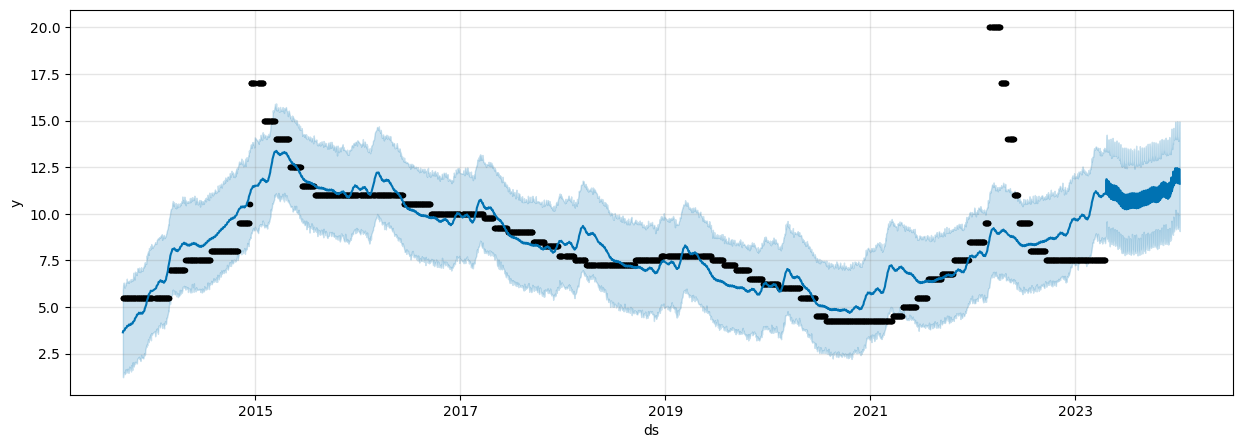

In [57]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_baseline.plot(forecast,ax=ax)
plt.show()

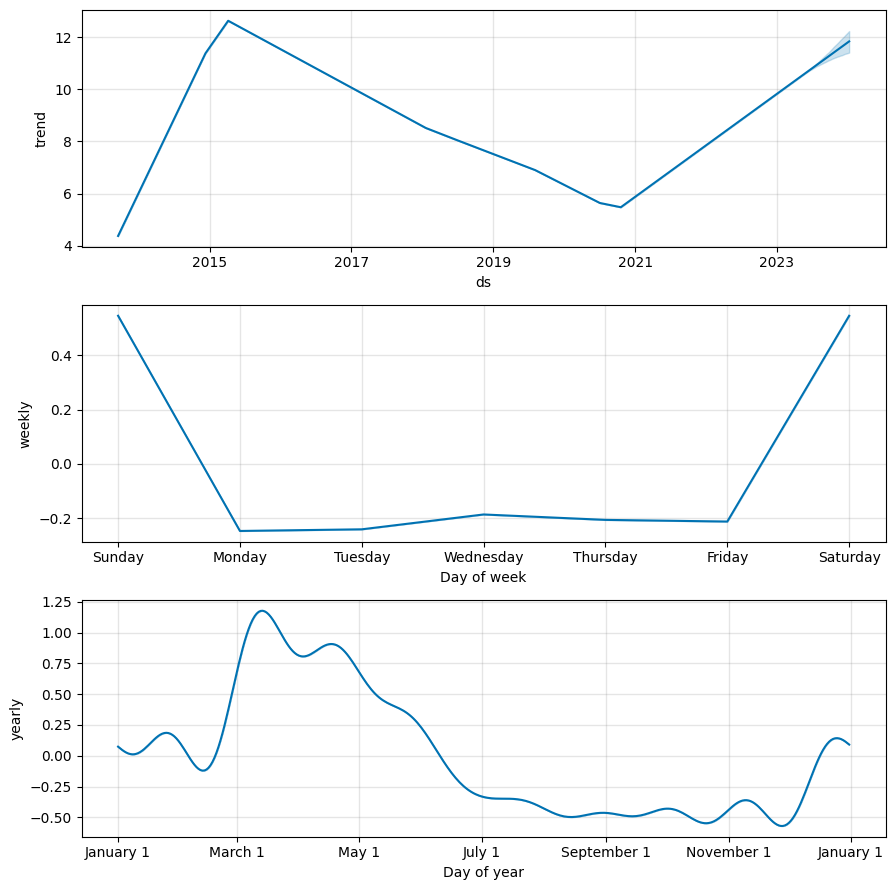

In [58]:
# Смотрим тренд, годовые и сезонные признаки
fig = model_baseline.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [59]:
# Создание df с прогнозом
df_test_forecast = model_baseline.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
260,2024-04-26,13.017796,10.519948,15.500587
261,2024-04-29,12.926869,10.540672,15.548491
262,2024-04-30,12.912788,10.501608,15.335575
263,2024-05-02,12.907287,10.496777,15.472948
264,2024-05-03,12.881852,10.544563,15.398661


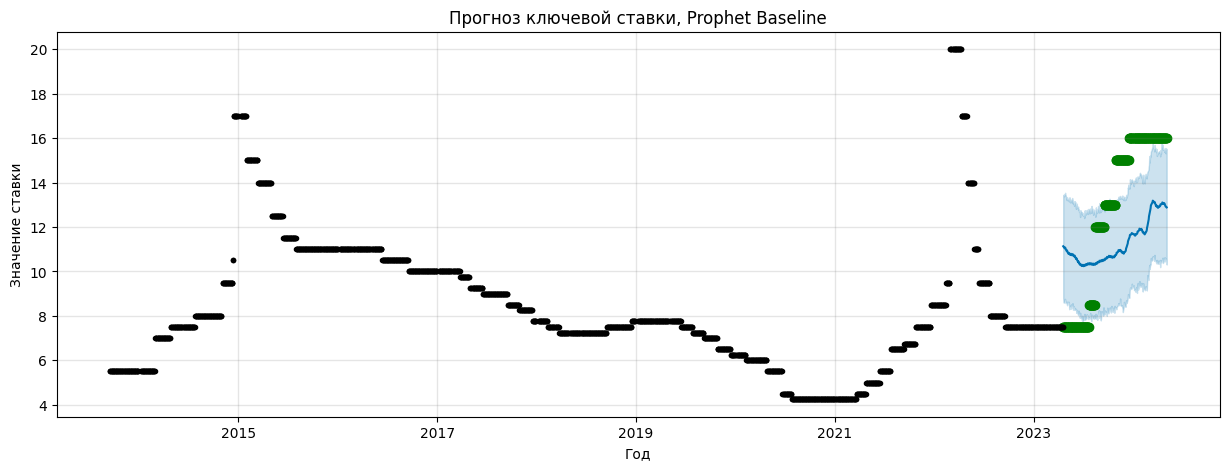

In [60]:
# Смотрим совпадение фактического курса с предсказанным курсом prophet baseline обученным на train
fig, ax = plt.subplots(figsize= (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
predict = model_baseline.predict(df_test)
fig = model_baseline.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet Baseline')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

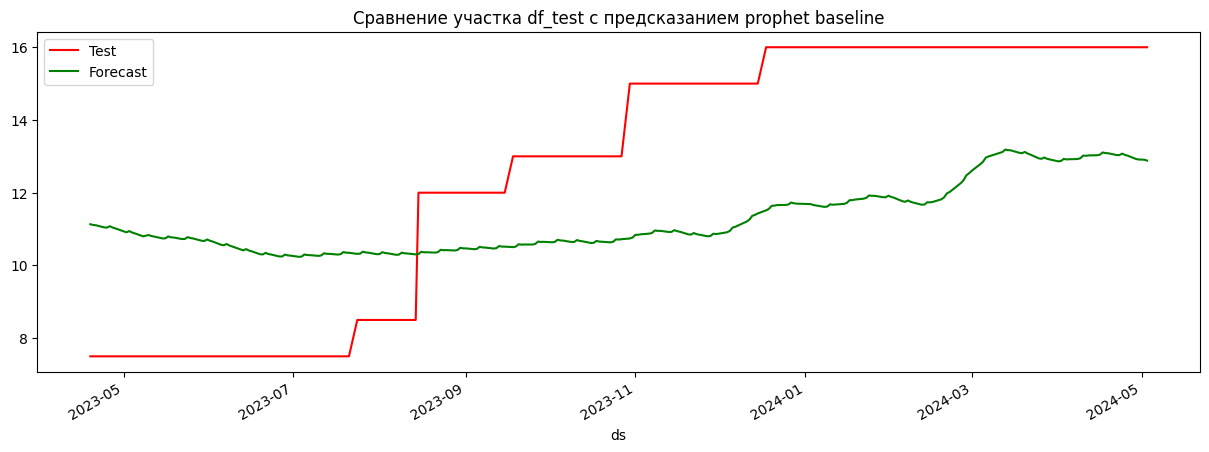

In [61]:
# Сравнение участка df_test с предсказанием prophet baseline
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet baseline')
plt.show()

In [62]:
# Просмотр метрик модели обученной на train
metrics = get_metrics(y_test=df_test['y'], y_pred=df_test_forecast['yhat'], name='Prophet_baseline')
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,3.116904,0.263591,10.471837,3.236022


Из приведенного выше графика мы видим, что существует разрыв в прогнозах и фактических данных. Поэтому нам нужно оптимизировать модель, добавив другие параметры, напрмиер, такие как праздники

# Prophet with holidays

In [63]:
# Создаем df праздников в РФ начиная с 2013 по сегодня
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]).items()):
    new_row = pd.DataFrame({'ds': date, 'holiday': "RU-Holidays"}, index=[0])
    holiday = pd.concat([holiday, new_row], ignore_index=True)  

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [64]:
# Тренировка модели с праздниками
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(df_train)

02:16:22 - cmdstanpy - INFO - Chain [1] start processing
02:16:23 - cmdstanpy - INFO - Chain [1] done processing


In [65]:
# Создание df с прогнозом
future = model_with_holidays.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2645,2024-01-04,11.127870,8.824824,13.326707
2646,2024-01-05,11.123054,8.678296,13.669256
2647,2024-01-06,11.878568,9.293416,14.164828
2648,2024-01-07,11.875426,9.549796,14.161091
2649,2024-01-08,11.074702,8.732854,13.445211


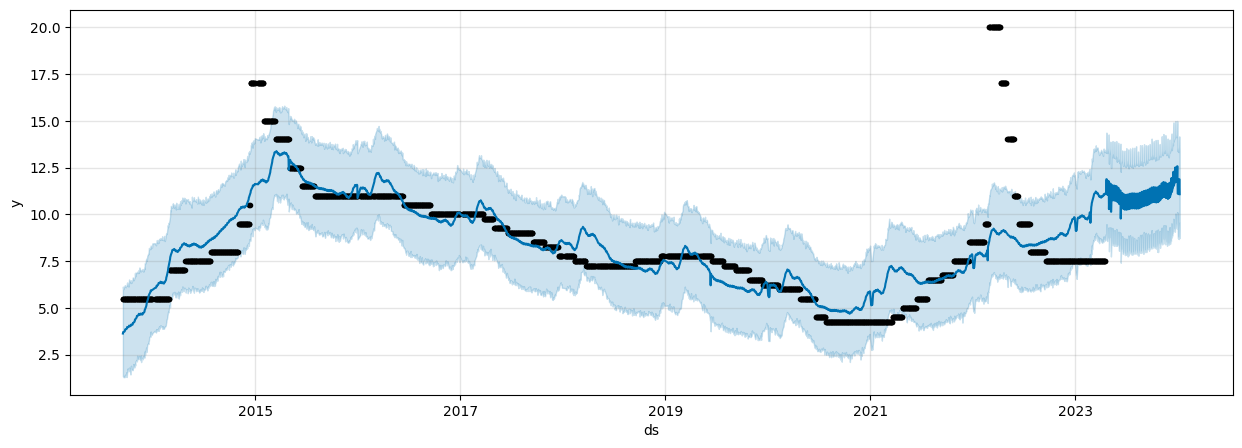

In [66]:
# Смотрим график прогноза с праздниками
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

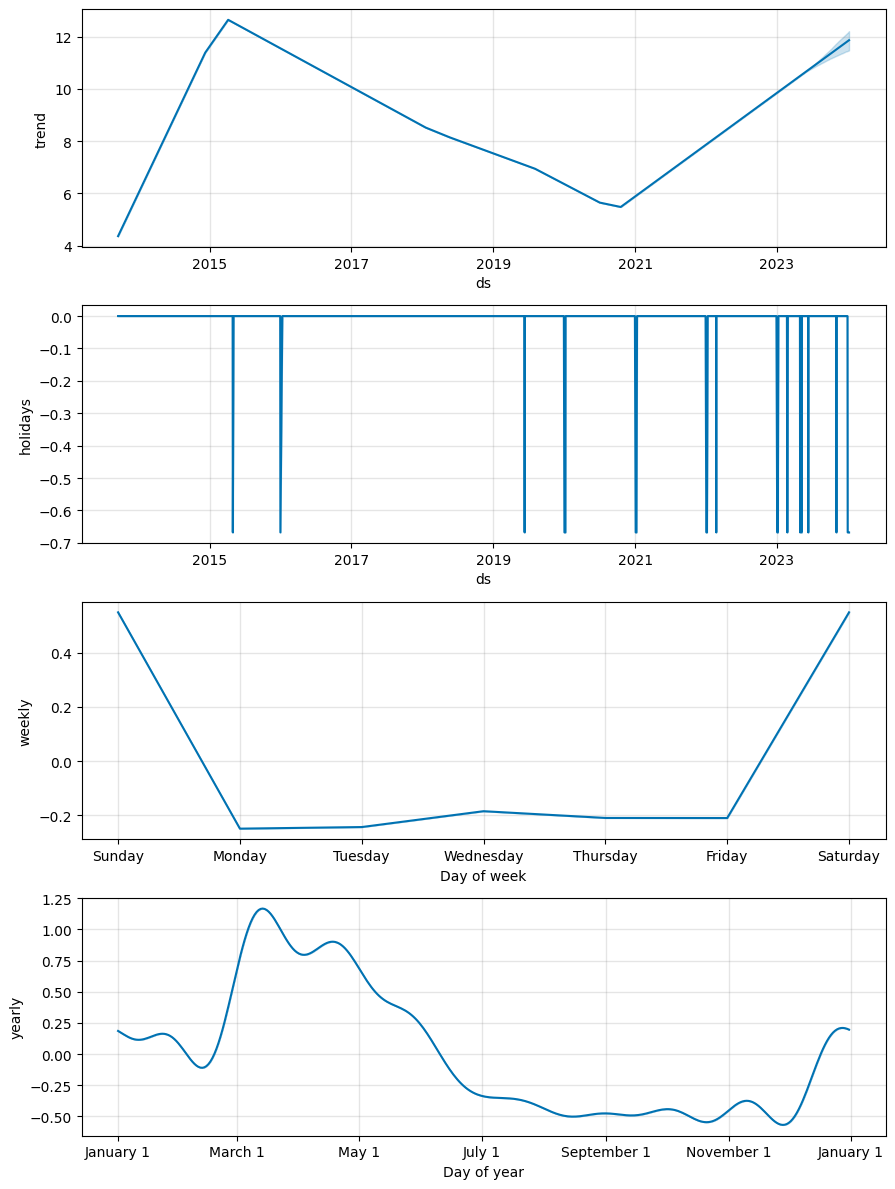

In [67]:
# Смотрим тренд, годовые и сезонные признаки обученной модели с праздниками
fig = model_with_holidays.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [68]:
# Создание df с прогнозом
df_test_forecast_holiday = model_with_holidays.predict(df_test)
df_test_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
260,2024-04-26,13.049892,10.702611,15.377783
261,2024-04-29,12.955224,10.560108,15.504281
262,2024-04-30,12.940717,10.475908,15.326770
263,2024-05-02,12.932767,10.425713,15.479244
264,2024-05-03,12.912018,10.368182,15.462085


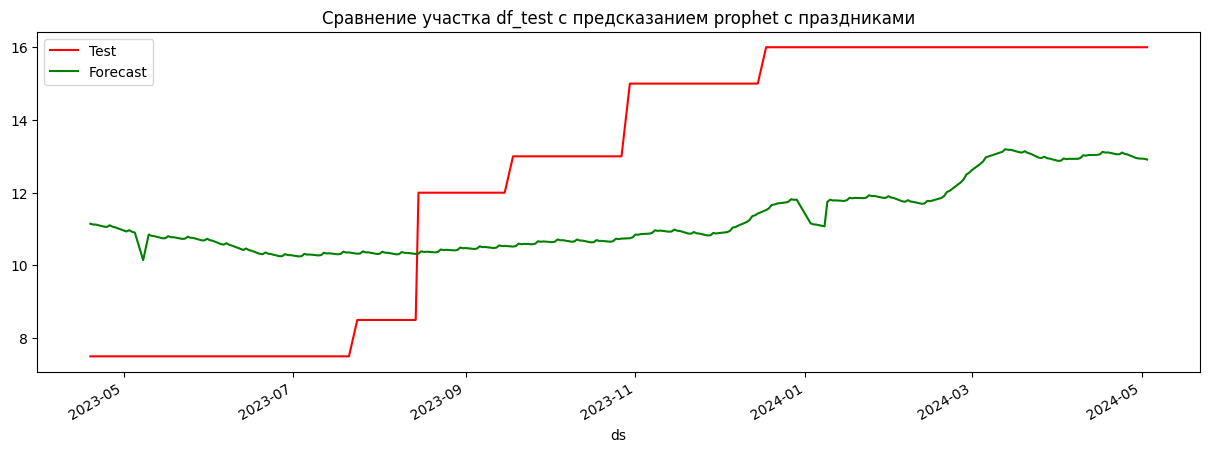

In [69]:
# Сравнение участка df_test с предсказанием prophet_with_holidays
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet с праздниками')
plt.show()

In [70]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_holiday['yhat'], name='Prophet_with_holidays')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,3.116904,0.263591,10.471837,3.236022
0,Prophet_with_holidays,3.113804,0.263438,10.465035,3.234971


Из метрик и графиков видим, что модель с праздниками показывает результаты немного изменились.

# Тюнинг тест модели

In [71]:
# Создание сетки параметров и подсчёт количества вариаций обучения
params_grid = {
    'changepoint_prior_scale': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.3, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1, 10], 
    'holidays_prior_scale': [0.01, 0.1, 1, 10],
    'seasonality_mode': ('multiplicative','additive')
}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt + 1

print('Количество моделей для обучения по сетке:', cnt)

Количество моделей для обучения по сетке: 672


In [72]:
"""Обучение тестовой модели по сетке параметров"""
# Создаем пустой DataFrame для сохранения метрик и параметров
model_grid_metrics = pd.DataFrame()
model_grid_parameters = pd.DataFrame(columns = ['Parameters'])

# Проходимся по сетке гиперпараметров
for p in tqdm(grid):
    #print(p)
#for p in grid:
#    print(p)
    
    # Создаем модель Prophet с текущими гиперпараметрами
    model_grid = Prophet(
        changepoint_prior_scale = p['changepoint_prior_scale'],
        seasonality_prior_scale = p['seasonality_prior_scale'],
        holidays_prior_scale = p['holidays_prior_scale'],
        seasonality_mode = p['seasonality_mode'],
        #changepoint_range = p['changepoint_range'],
        #daily_seasonality = p['daily_seasonality'],
        #weekly_seasonality = p['weekly_seasonality'],
        #yearly_seasonality = p['yearly_seasonality'],
        #holidays=holiday,
    )

    # Добавляем праздники в модель
    #model_grid.add_country_holidays(country_name='RU')

    # Обучаем модель данными
    model_grid.fit(df_train)

    # Создаем фрейм данных для предсказаний
    model_grid_future = model_grid.make_future_dataframe(periods=pred_days, freq='D', include_history=False)

    # Делаем предсказания
    model_grid_forecast = model_grid.predict(model_grid_future)

    # Вычисляем метрики и добавляем новую строку в df
    model_grid_metrics = pd.concat([model_grid_metrics, get_metrics(y_test=df_test['y'], y_pred=model_grid_forecast['yhat'], name='Prophet_with_grid ')])
    model_grid_parameters = pd.concat([model_grid_parameters, pd.DataFrame({'Parameters': [p]})], ignore_index=True)


  0%|          | 0/672 [00:00<?, ?it/s]02:16:28 - cmdstanpy - INFO - Chain [1] start processing
02:16:28 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/672 [00:00<11:04,  1.01it/s]02:16:29 - cmdstanpy - INFO - Chain [1] start processing
02:16:29 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 2/672 [00:01<10:29,  1.06it/s]02:16:30 - cmdstanpy - INFO - Chain [1] start processing
02:16:31 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 3/672 [00:03<11:43,  1.05s/it]02:16:31 - cmdstanpy - INFO - Chain [1] start processing
02:16:32 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 4/672 [00:04<12:28,  1.12s/it]02:16:32 - cmdstanpy - INFO - Chain [1] start processing
02:16:33 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 5/672 [00:05<11:53,  1.07s/it]02:16:33 - cmdstanpy - INFO - Chain [1] start processing
02:16:34 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 6/672 [00:06<11:05,  1.00it/s]0

In [73]:
# Сброс индексов для будущего объединения с df параметров сетки
model_grid_metrics = model_grid_metrics.reset_index(drop=True)

In [74]:
# Объединение DataFrame по столбцам
metrics_parameters_with_grid = pd.concat([model_grid_metrics, model_grid_parameters], axis=1)
metrics_parameters_with_grid

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,5.658724,0.385283,45.975647,6.780534,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
1,Prophet_with_grid,5.935068,0.407131,49.826029,7.058755,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
2,Prophet_with_grid,5.699629,0.390499,46.123222,6.791408,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
3,Prophet_with_grid,5.986993,0.410948,50.626549,7.115234,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
4,Prophet_with_grid,5.864600,0.401506,48.840309,6.988584,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
...,...,...,...,...,...,...
667,Prophet_with_grid,12.735513,1.012200,292.970378,17.116377,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
668,Prophet_with_grid,4.392759,0.331646,23.404191,4.837788,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
669,Prophet_with_grid,4.518126,0.339503,24.935467,4.993542,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
670,Prophet_with_grid,4.499007,0.337886,24.753359,4.975275,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."


In [75]:
# Сортировка по метрике
metrics_parameters_with_grid = metrics_parameters_with_grid.sort_values(by=['MAE'])
metrics_parameters_with_grid = metrics_parameters_with_grid.reset_index(drop=True)
metrics_parameters_with_grid.head()

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,3.622929,0.301974,14.542563,3.813471,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
1,Prophet_with_grid,3.622929,0.301974,14.542563,3.813471,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
2,Prophet_with_grid,3.622929,0.301974,14.542563,3.813471,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
3,Prophet_with_grid,3.622929,0.301974,14.542563,3.813471,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
4,Prophet_with_grid,3.631664,0.302183,14.600741,3.821092,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."


## Лучшие параметры после обучения по сетке

In [76]:
# Сохранение в переменную лучших параметров после обучения по сетке
best_params = metrics_parameters_with_grid['Parameters'][0]

# Просмотр лучших параметров
best_params

{'changepoint_prior_scale': 0.05,
 'holidays_prior_scale': 0.01,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 10}

In [77]:
# Обучение модели на лучших параметрах
final_test_model = Prophet(**best_params)
final_test_model.fit(df_train)

02:36:08 - cmdstanpy - INFO - Chain [1] start processing
02:36:08 - cmdstanpy - INFO - Chain [1] done processing


In [78]:
# Создание df с прогнозом
future = final_test_model.make_future_dataframe(periods=pred_days, freq='D')
forecast = final_test_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2645,2024-01-04,11.659792,9.304248,14.036195
2646,2024-01-05,11.648140,9.065118,13.946226
2647,2024-01-06,12.400253,9.850939,14.808188
2648,2024-01-07,12.398768,9.806959,14.841904
2649,2024-01-08,11.609362,9.251341,14.111242


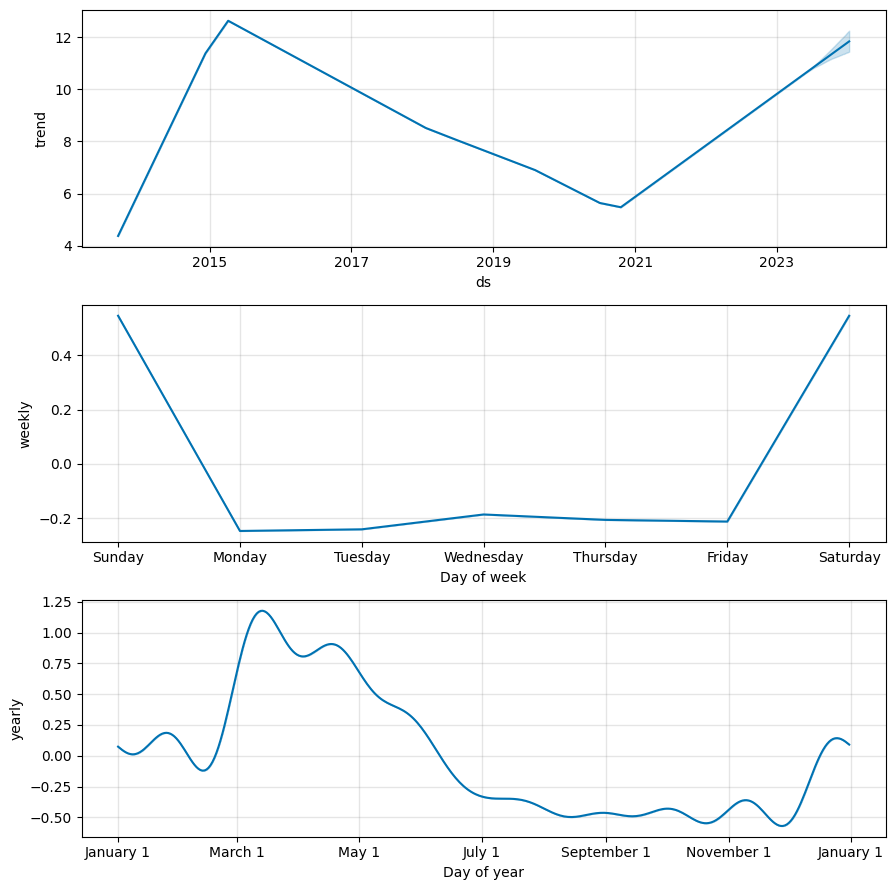

In [79]:
# Смотрим тренд, годовые и сезонные признаки
fig = final_test_model.plot_components(forecast)

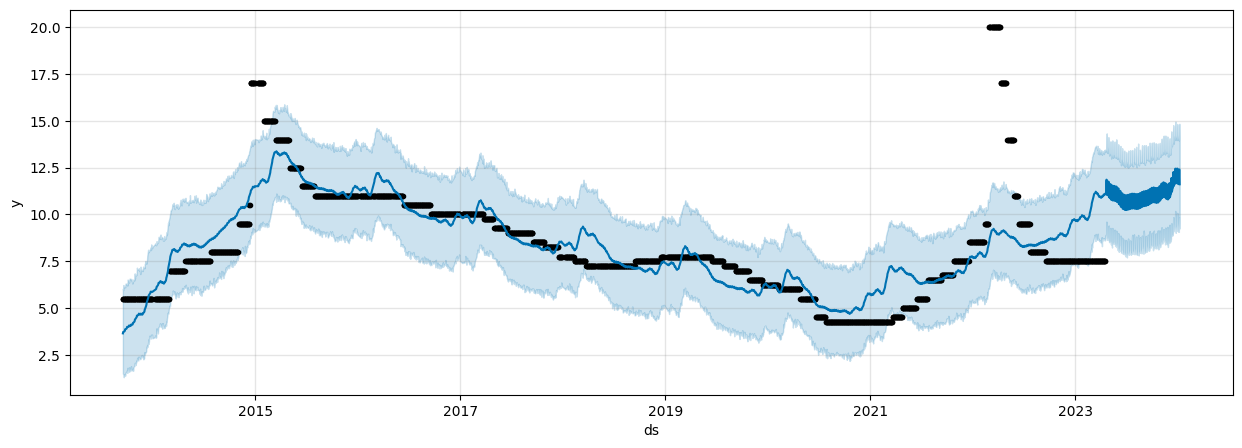

In [80]:
# Смотрим график прогноза после обучния на лучших параметрах
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast,ax=ax)
plt.show()

## Сравнение фактов и прогнозов

In [81]:
# Создание df с прогнозом
df_test_forecast_final = final_test_model.predict(df_test)
df_test_forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
260,2024-04-26,13.017796,10.471672,15.559893
261,2024-04-29,12.926869,10.665874,15.426407
262,2024-04-30,12.912788,10.319547,15.264554
263,2024-05-02,12.907287,10.549523,15.355706
264,2024-05-03,12.881852,10.465712,15.596018


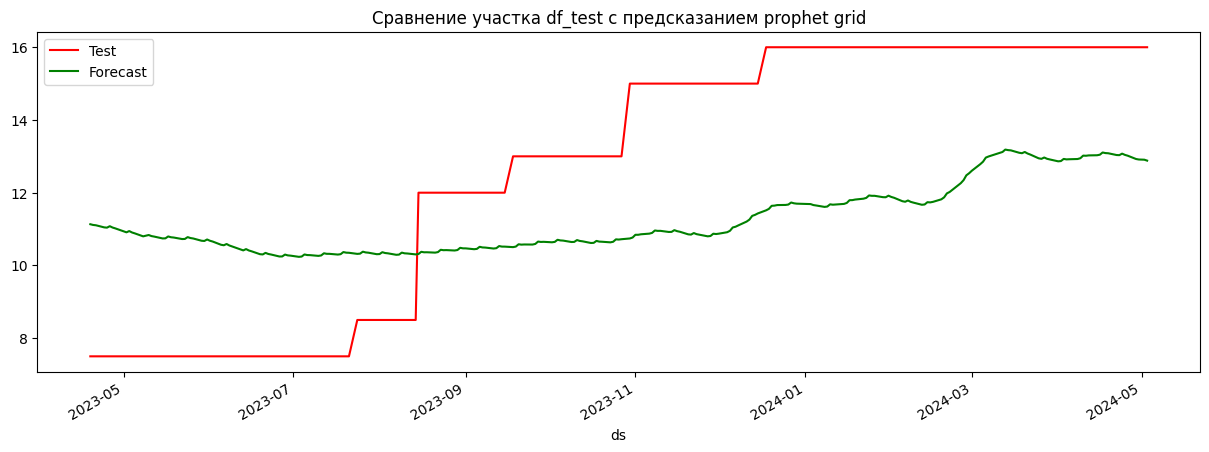

In [82]:
# Сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet grid')
plt.show()

In [83]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_final['yhat'], name='Prophet_with_grid')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,3.116904,0.263591,10.471837,3.236022
0,Prophet_with_holidays,3.113804,0.263438,10.465035,3.234971
0,Prophet_with_grid,3.116904,0.263591,10.471837,3.236022


In [84]:
# Сохранение модели в JSON файл
with open('../backend/final_test_model.json', 'w') as fout:
    fout.write(model_to_json(final_test_model))

# Baseline NeuralProphet on df_train для проверки модели

In [97]:
NeuralProphet = NeuralProphet()
NeuralProphet.set_plotting_backend("plotly-static")
metricsnp = NeuralProphet.fit(df_train)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.191% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (38) is too small than the required number                     for the learning rate finder (234). The results might not be optimal.


Finding best initial lr:   0%|          | 0/234 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [154]:
# Создание df с прогнозом
future_np = NeuralProphet.make_future_dataframe(df_train, periods = pred_days, n_historic_predictions = len(df_train))
forecast_np = NeuralProphet.predict(df_test)
forecast_np.tail()

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.191% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B


INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.981% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.981% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B


Predicting: 38it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly
260,2024-04-26,16.0,11.924620,10.838014,0.461109,0.625497
261,2024-04-29,16.0,11.986536,10.853825,0.495342,0.637369
262,2024-04-30,16.0,11.997857,10.859097,0.505839,0.632920
263,2024-05-02,16.0,12.048113,10.869637,0.525075,0.653401
264,2024-05-03,16.0,12.034002,10.874909,0.533701,0.625392


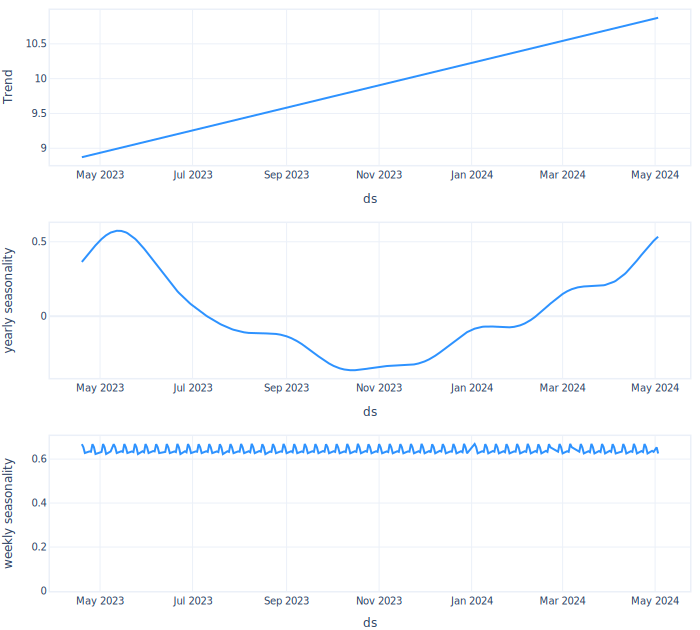

In [156]:
# Смотрим тренд, годовые и сезонные признаки
NeuralProphet.plot_components(forecast_np)

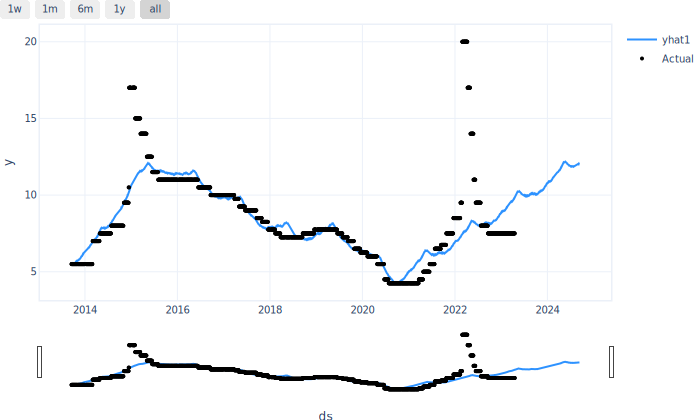

In [122]:
# Смотрим график прогноза после обучения
fig = NeuralProphet.plot(forecast_np, ax=ax)

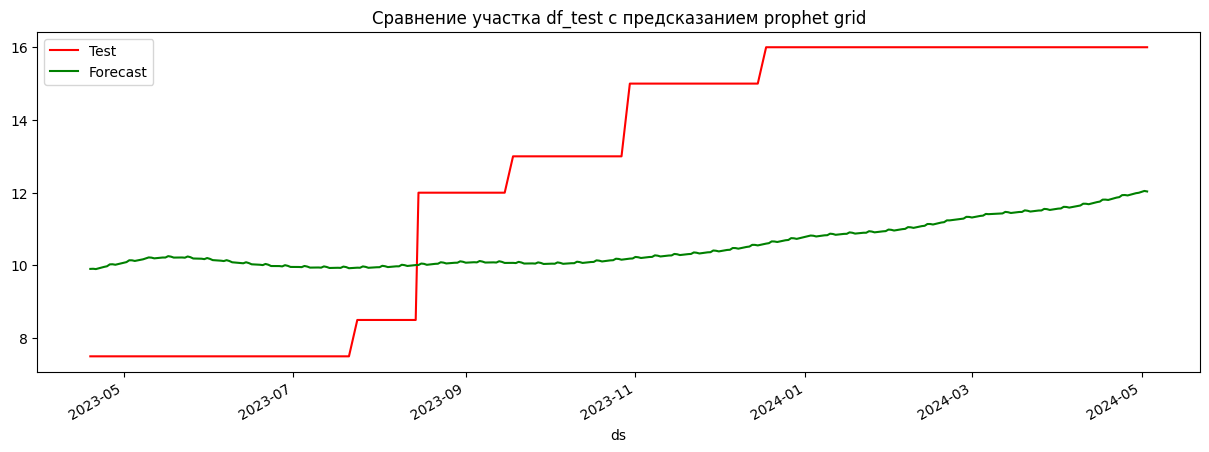

In [157]:
# Сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
forecast_np.plot(kind='line',x='ds',y='yhat1', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet grid')
plt.show()

In [159]:
# Сравниваем метрики после добавления NeuralProphet
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=forecast_np['yhat1'], name='NeuralProphet')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,3.116904,0.263591,10.471837,3.236022
0,Prophet_with_holidays,3.113804,0.263438,10.465035,3.234971
0,Prophet_with_grid,3.116904,0.263591,10.471837,3.236022
0,NeuralProphet,3.533535,0.281251,13.995221,3.741019


# Обучение и прогнозирование курса на df

# Prophet baseline on df

In [124]:
# Обучение модели на train
model_baseline = Prophet()
model_baseline.fit(df)

02:56:56 - cmdstanpy - INFO - Chain [1] start processing
02:56:57 - cmdstanpy - INFO - Chain [1] done processing


In [125]:
# Количество предсказанных дней
pred_days_forecast = 365

In [126]:
# Создание df с прогнозом
future = model_baseline.make_future_dataframe(periods=pred_days_forecast, freq='D')
forecast = model_baseline.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3010,2025-04-29,15.856909,13.281104,18.714052
3011,2025-04-30,15.853759,13.175849,18.529969
3012,2025-05-01,15.804309,13.224681,18.490120
3013,2025-05-02,15.753549,13.096889,18.441835
3014,2025-05-03,16.479763,14.010878,19.138671


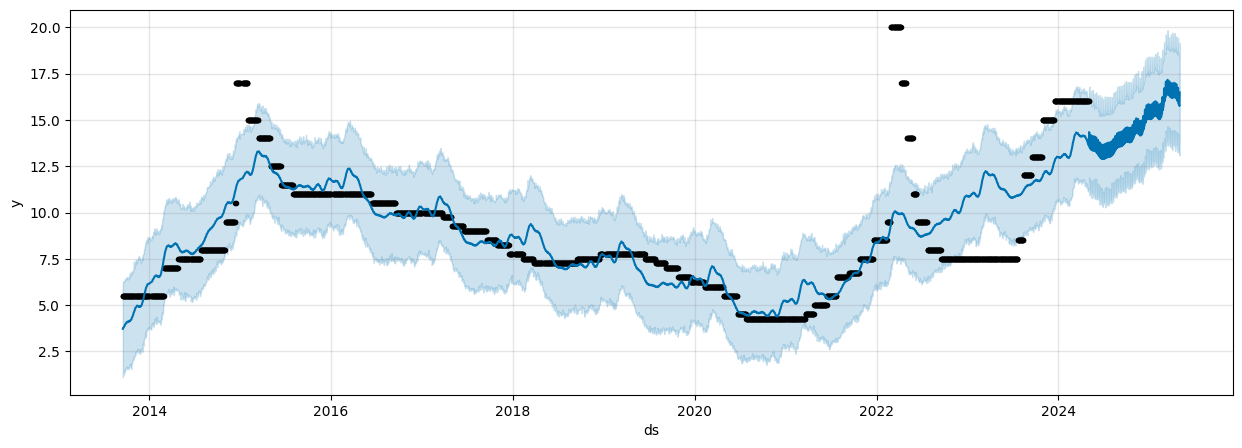

In [127]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_baseline.plot(forecast,ax=ax)
plt.show()

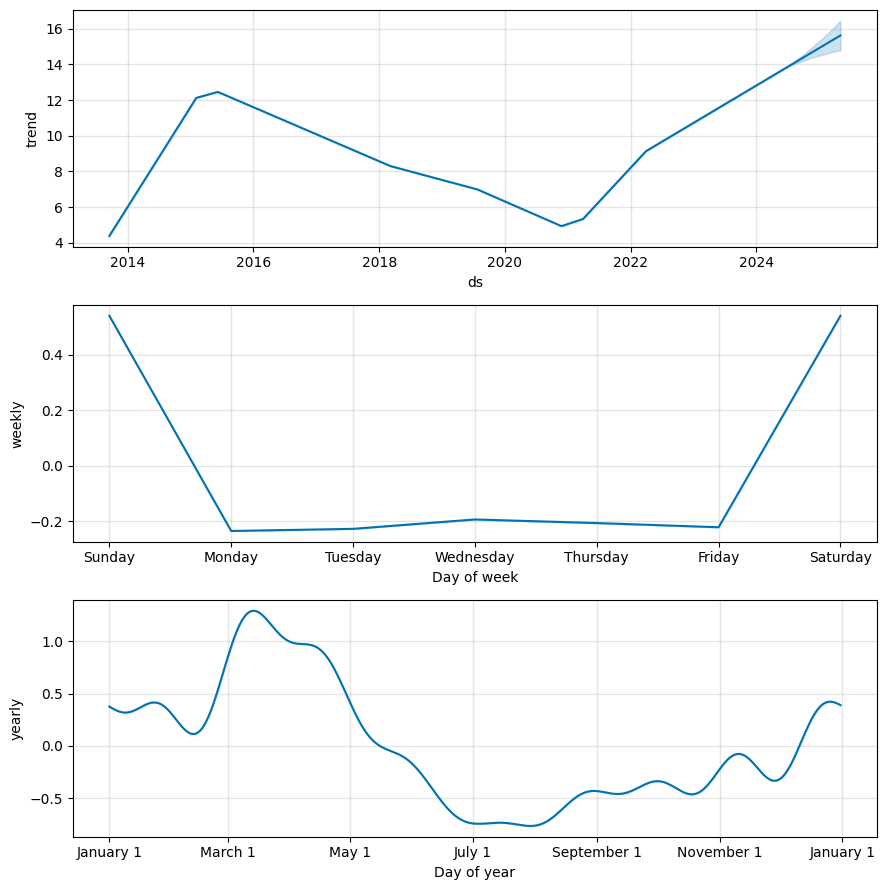

In [128]:
# Смотрим тренд, годовые и сезонные признаки
fig = model_baseline.plot_components(forecast)
plt.show()